In [34]:
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import os
import sklearn
import csv
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D , Dense , Flatten , Dropout
from keras.layers import Dense, Dropout, BatchNormalization

from keras.optimizers import RMSprop
import noisereduce as nr  #new library
import gzip


Using TensorFlow backend.


Bu kütüphaneyle işleyeceğimiz sesi dinleyebiliriz.

In [29]:
from IPython.display import Audio
Audio(r"C:\Users\Beyza\Desktop\1.wav") # 

In [40]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = 20, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size                #Kesim sayısı
    samples = samples[:len(samples) - truncate_size]                          #Windows sayısı
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1) 
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])
    
    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    print(specgram)

    return specgram

In [41]:
N_FFT = 1024       # Number of frequency bins for Fast Fourier Transform
HOP_SIZE = 1024    # Number of audio frames between STFT columns
N_MELS = 128     # Mel band parameters -- insan kulağı için 128 
SR = 16000
WIN_SIZE = 1024     # number of samples in each STFT window
WINDOW_TYPE = 'hann' # the windowin function
FEATURE = 'mel'      # feature representation
plt.rcParams['figure.figsize'] = (10,5)

In [54]:
def specgram(sample , sampling_rate):
    
    #Only FFT Apply
    O_fft = librosa.stft(sample, n_fft = N_FFT, 
                      hop_length = HOP_SIZE, 
                      window = WINDOW_TYPE, 
                      win_length = WIN_SIZE)
    O_stft = np.abs(O_fft)**2
    
    
    # mel-spectrogram 
    melspec = librosa.feature.melspectrogram(y=None, 
                                             S=O_stft, 
                                             sr=sampling_rate, 
                                             n_fft=N_FFT, 
                                             hop_length=HOP_SIZE, 
                                             n_mels=N_MELS, 
                                             htk=True, 
                                             fmin=0.0, 
                                             fmax=SR/2.0)
    


    plt.figure(figsize=(14, 5))                 #görselleştirme
    librosa.display.specshow(melspec, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()
    
    return melspec
    #For Comparison
    '''
    plt.subplot(3+(val*2),1+(val*2),1)
    librosa.display.waveplot(sample, sr=sampling_rate)
    plt.subplot(3+(val*2),1+(val*2),2)
    librosa.display.specshow(librosa.core.amplitude_to_db(O_stft),
                                             sr=SR, 
                                             hop_length=HOP_SIZE, 
                                             x_axis='time', 
                                             y_axis='linear')
    plt.subplot(3+(val*2),1+(val*2),3)
    librosa.display.specshow(librosa.core.amplitude_to_db(melspec, ref=1.0),
                                             sr=SR,
                                             hop_length=HOP_SIZE, 
                                             x_axis='time', 
                                             y_axis='mel')
   '''

### Signal visualization 

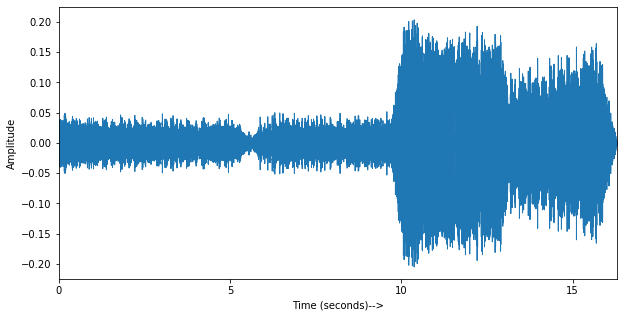

In [37]:
from librosa import display
sample , sampling_rate = librosa.load(r'C:\Users\Beyza\Desktop\0.wav' , sr=16000)

plt.figure()
librosa.display.waveplot(y=sample,sr=sampling_rate)
y = nr.reduce_noise(audio_clip=sample, noise_clip=sample, prop_decrease = 1, verbose=False) 
plt.xlabel("Time (seconds)-->")
plt.ylabel("Amplitude")
plt.show()

0 .dosya path-> ['0 .wav', '1.wav', '2.wav', '3.wav']
0 .wav . file load: [ 0.          0.          0.         ...  0.00037243  0.00042962
 -0.00026256]
Spectrogram Func1
[[-32.2361913  -32.2361913  -32.2361913  -32.2361913  -32.2361913
  -32.23602332 -31.77754246 -30.09029657 -29.28462202 -27.34656072
  -24.82921737 -23.5325882  -22.42345866 -20.91014459 -19.34890385
  -17.94939707 -16.5668861  -15.17116244 -14.43229653 -14.30748912
  -14.4381886  -14.71544577 -15.11326304 -15.69353666 -16.4910112
  -17.76959161 -22.3818393  -17.24045369 -16.04055415 -15.34674899
  -14.87355322 -14.53796178 -14.26770269 -14.04101047 -13.87141092
  -13.74840897 -13.64744199 -13.56304423 -13.49212306 -13.4321565
  -13.3909669  -13.37004437 -13.35687026 -13.34103099 -13.31910532
  -13.29594968 -13.29099263 -13.32528576 -13.39469228 -13.46146229
  -13.4825173  -13.45223811 -13.3988427  -13.34723333 -13.31130922
  -13.30544289 -13.33967208 -13.40806232 -13.48701863 -13.55364174
  -13.60927905 -13.63333078 

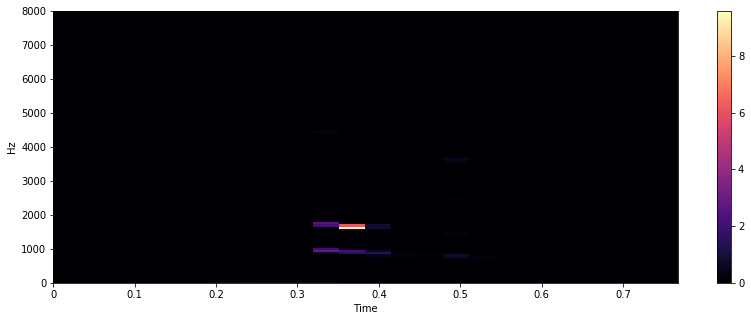

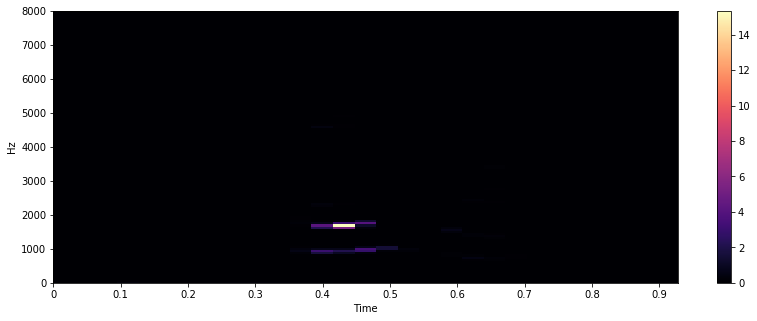

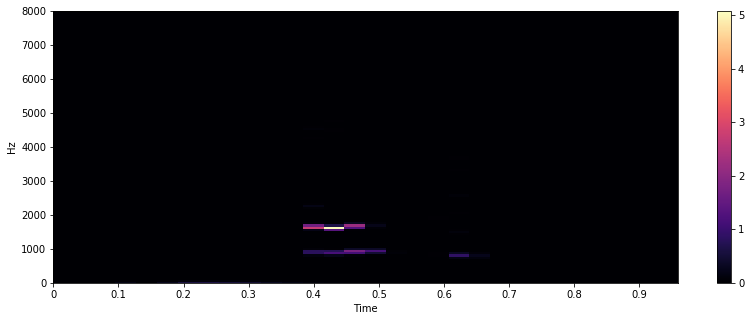

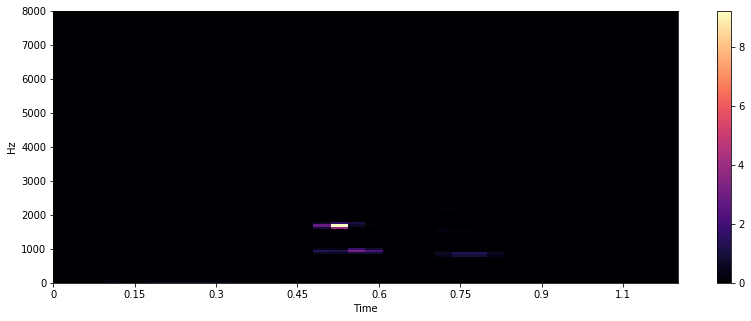

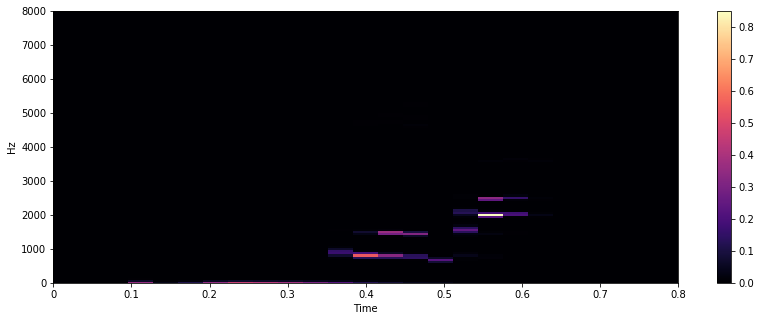

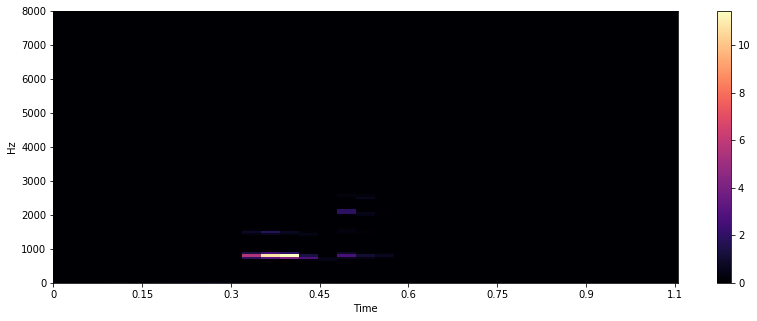

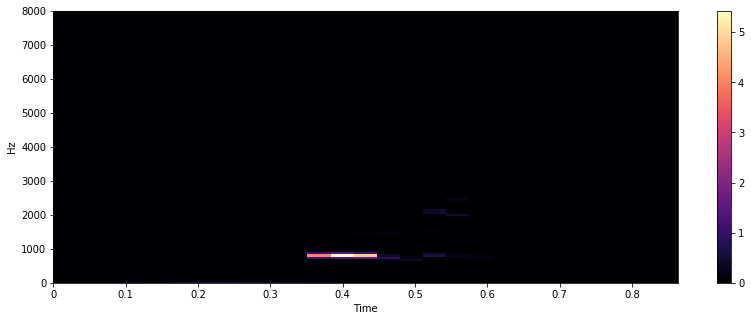

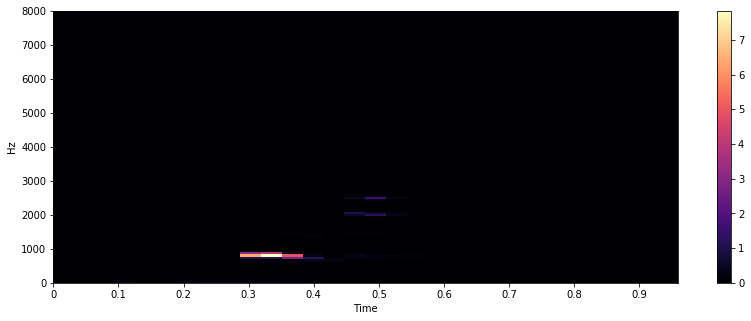

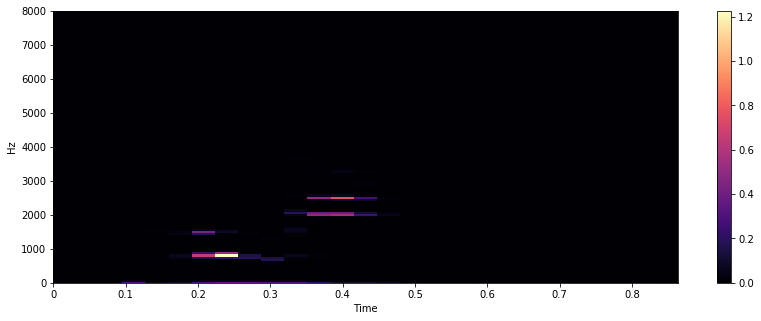

In [55]:
classes = 2  # 2 human voice
current_path = r"C:\Users\Beyza\Desktop\Ses_Verisi"
SAMPLING_RATE = 16000

def load_sample(path):
    
    sample , sampling_rate = librosa.load(path , sr=16000) 
    # noise reduce
    sample = nr.reduce_noise(audio_clip=sample, noise_clip=sample, prop_decrease = 1, verbose=False)
    return sample


for i in range (classes):
    path = os.path.join(current_path + '\\Train\\' + str(i)) 
    noisepath = os.listdir(path)  
    print(i,".dosya path->",noisepath)

    
    
    for path_new in noisepath:
       
            sample = load_sample(path +"\\" +path_new)
            print(path_new,". file load:" ,sample)
            print("Spectrogram Func1") 
            spec = spectrogram(sample,SAMPLING_RATE)  #karşılaştırma için             
            magnitude_spectrograms = tf.abs(spec)
            print(magnitude_spectrograms)             #spectrogram büyüklüğü
            
            print("Spectrogram Func2") 
            spec2= specgram(sample,SAMPLING_RATE)     # spectrogramın her evresi yapılmadı loglanması gerekiyor.
            print(spec2)



### Loglanma işleminin de dahil edilmiş hali.

0 .dosya path-> ['0 .wav', '1.wav', '2.wav', '3.wav']
0 .wav . file load: [ 0.          0.          0.         ...  0.00037243  0.00042962
 -0.00026256]
<class 'numpy.ndarray'>
Tensor("Abs_51:0", shape=(128, 24), dtype=float64)


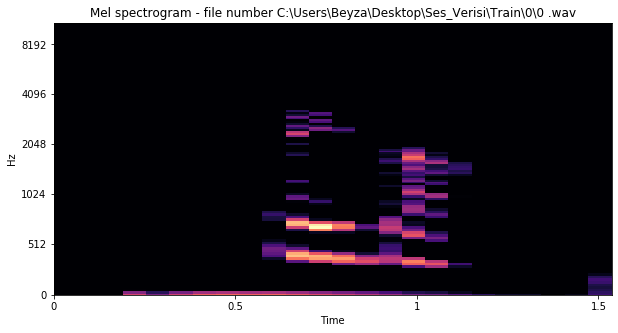

1.wav . file load: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -7.43514589e-04
 -5.29975549e-04 -3.42739629e-05]
<class 'numpy.ndarray'>
Tensor("Abs_52:0", shape=(128, 29), dtype=float64)


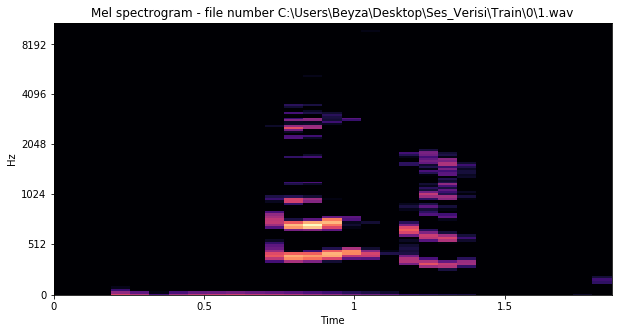

2.wav . file load: [ 0.          0.          0.         ... -0.00068609 -0.00054483
 -0.00079698]
<class 'numpy.ndarray'>
Tensor("Abs_53:0", shape=(128, 30), dtype=float64)


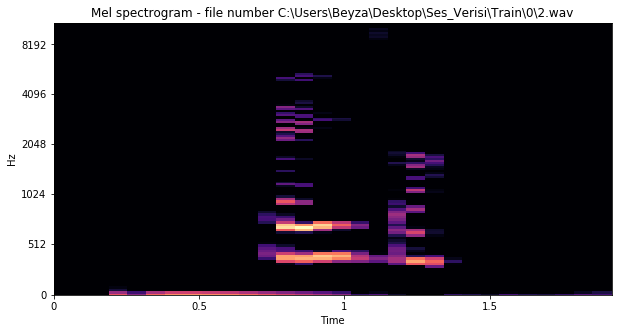

3.wav . file load: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.22779855e-06
 -1.72364121e-05 -2.80826526e-05]
<class 'numpy.ndarray'>
Tensor("Abs_54:0", shape=(128, 36), dtype=float64)


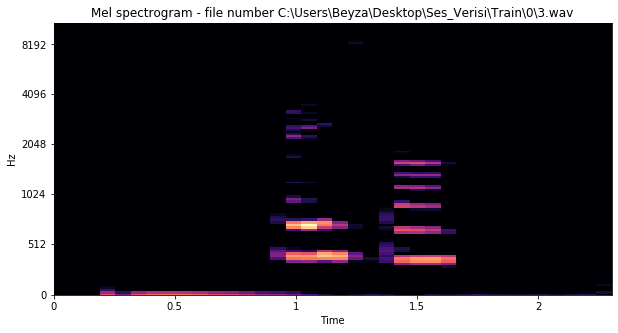

1 .dosya path-> ['0.wav', '1.wav', '2.wav', '3.wav', '4.wav']
0.wav . file load: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.20788696e-05
 -5.52642889e-05 -2.71967362e-04]
<class 'numpy.ndarray'>
Tensor("Abs_55:0", shape=(128, 25), dtype=float64)


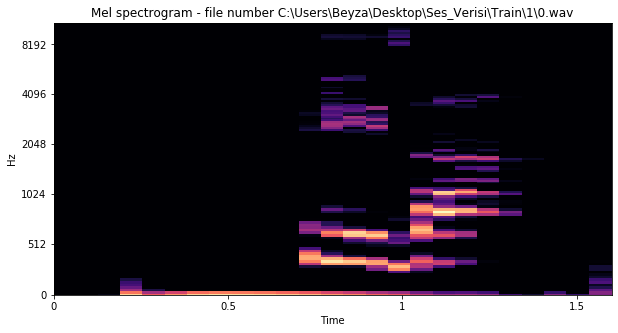

1.wav . file load: [ 0.          0.          0.         ... -0.00246915 -0.00263984
 -0.00054217]
<class 'numpy.ndarray'>
Tensor("Abs_56:0", shape=(128, 33), dtype=float64)


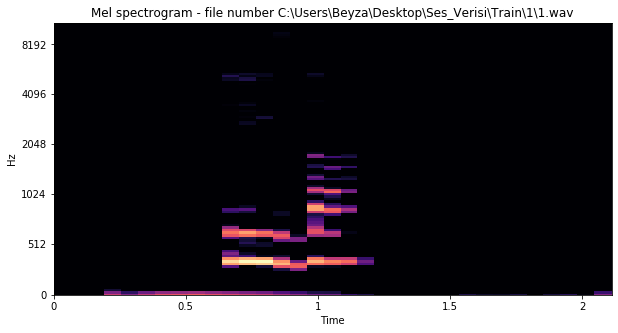

2.wav . file load: [ 0.          0.          0.         ... -0.00181114 -0.00173182
 -0.00188653]
<class 'numpy.ndarray'>
Tensor("Abs_57:0", shape=(128, 27), dtype=float64)


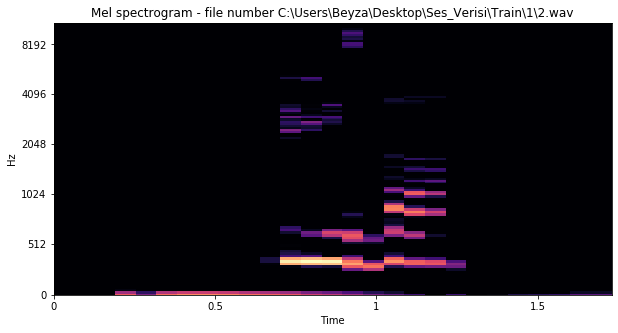

3.wav . file load: [ 0.          0.          0.         ... -0.00054432 -0.00036492
 -0.00019197]
<class 'numpy.ndarray'>
Tensor("Abs_58:0", shape=(128, 30), dtype=float64)


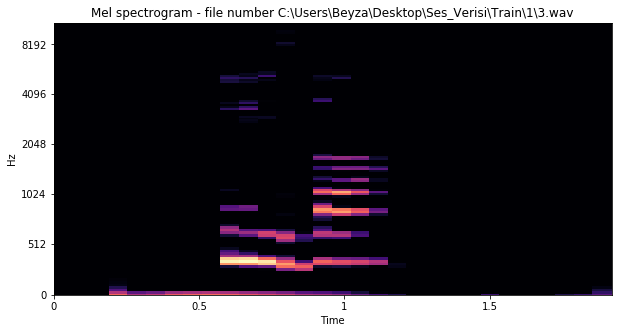

4.wav . file load: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -5.16209462e-04
 -4.09185866e-04 -5.16080980e-05]
<class 'numpy.ndarray'>
Tensor("Abs_59:0", shape=(128, 27), dtype=float64)


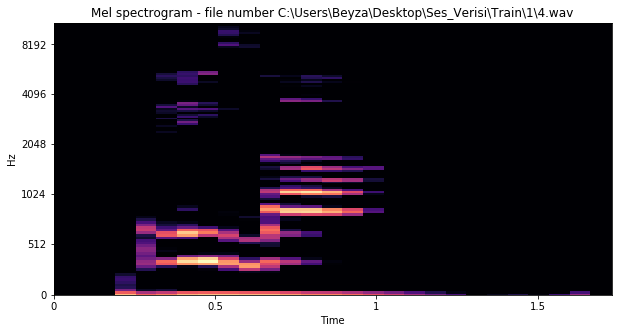

In [50]:
sr = 16000
data  = np.ones(9)  
label = [] 
classes = 2

for i in range (classes):
    path = os.path.join(current_path + '\\Train\\' + str(i)) 
    datapath = os.listdir(path)  
    print(i,".dosya path->",datapath)
 
    for path_new in datapath:
       
            sample = load_sample(path +"\\" +path_new)
            print(path_new,". file load:" ,sample)
        

            #creating logmelspec 
            logmelspec = librosa.core.amplitude_to_db(   # Emin olunan spectrogramın son hali
                    librosa.feature.melspectrogram(
                                        y=sample, 
                                        S=np.abs(
                                            librosa.stft(
                                                sample, n_fft = N_FFT, 
                                                hop_length = HOP_SIZE, 
                                                window = WINDOW_TYPE, 
                                                win_length = WIN_SIZE)
                                                )**2, 
                                        sr=SAMPLING_RATE, 
                                        n_fft=N_FFT, 
                                        hop_length=HOP_SIZE, 
                                        n_mels=N_MELS, 
                                        htk=True, 
                                        fmin=0.0, 
                                        fmax=sr/2.0), 
                                        ref=1.0)
            print(type(logmelspec))
            magnitude_spectrograms = tf.abs(logmelspec)
            print(magnitude_spectrograms)              
            plt.figure()
            data = logmelspec
            label.append(i)
            #print(type(label))
            
            #plotting logmelspec
            librosa.display.specshow(logmelspec,
                                    sr=SAMPLING_RATE,
                                    hop_length=HOP_SIZE, 
                                    x_axis='time', 
                                    y_axis='mel')
            
            plt.title('Mel spectrogram - file number '+str(path +"\\" +path_new))
            plt.show()
            

            #saving logmelspec
            '''
            f = gzip.open(str(path +"\\" +path_new)+'.npy.gznpy.gz', 'wb')   #spectrogramların kaydedilmesi
            logmelspec.dump(f)
            f.close()
            '''

### Verilerin Özellikleri Çıkarıldı Ve Listelendi.

In [58]:

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
for i in range (classes):
    path = os.path.join(current_path + '\\Train\\' + str(i)) 
    datapath = os.listdir(path)  
    print(i,".dosya path->",datapath)
 
    for path_new in datapath:
        
               
        path_name =  path +"\\" +path_new           
        y, sr = librosa.load(path_name, mono=True, duration=30)  
        rmse=librosa.feature.rms(y=y)[0]                         #rmse yeni sürüm farkı       
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)    
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        #-------------------------------------özellikler çıkarıldı----------------------------------------
        
        to_append = f'{path_new} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {i}'
        #print("classes :",i)
        
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

            

0 .dosya path-> ['0 .wav', '1.wav', '2.wav', '3.wav']
1 .dosya path-> ['0.wav', '1.wav', '2.wav', '3.wav', '4.wav']


In [69]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = pd.read_csv('dataset.csv')
data.head()                                             #Dropping unneccesary columns 
data = data.drop(['filename'],axis=1)                      
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()                                #Encoding the Labels
y = encoder.fit_transform(genre_list)                   #Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(data.iloc[:])

       chroma_stft         rmse  spectral_centroid  spectral_bandwidth  \
0         0.391184     0.024518        1108.948351         1704.155046   
1.wav     0.024154  1180.646681        1733.197480         2358.976031   
2.wav     0.019034  1180.686723        1781.060964         2211.594543   
3.wav     0.018267  1111.790872        1763.357427         2126.459307   
0.wav     0.027263  1166.924550        1918.801479         2468.604973   
1.wav     0.019793  1227.307379        2025.721130         2757.822650   
2.wav     0.024989  1171.621253        1889.735169         2553.927612   
3.wav     0.023153  1234.985931        2017.295422         2928.382704   
4.wav     0.023437  1434.799318        2071.562180         3368.200354   

           rolloff  zero_crossing_rate       mfcc1       mfcc2      mfcc3  \
0      2282.850811            0.031881 -453.709991  111.256760  17.898661   
1.wav     0.034625         -451.099152  109.717712   24.025431  20.179230   
2.wav     0.040619         -